In [86]:
import folktables
from folktables import ACSDataSource
import numpy as np
#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df
ACSEmployment = folktables.BasicProblem(
    features=[
       'AGEP', #age; for range of values of features please check Appendix B.4 of Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
       'SCHL', #educational attainment
       'MAR', #marital status
       'RELP', #relationship
       'DIS', #disability recode
       'ESP', #employment status of parents
       'CIT', #citizenship status
       'MIG', #mobility status (lived here 1 year ago)
       'MIL', #military service
       'ANC', #ancestry recode
       'NATIVITY', #nativity
       'DEAR', #hearing difficulty
       'DEYE', #vision difficulty
       'DREM', #cognitive difficulty
       'SEX', #sex
       'RAC1P', #recoded detailed race code
       'GCL', #grandparents living with grandchildren
    ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group='DIS',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True) #data for Florida state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [87]:
from aif360.datasets import StandardDataset
import pandas as pd
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes,
                      protected_attribute_names = protected_attribute_names,
                      privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]

/opt/anaconda3/envs/AIETHic/lib/python3.10/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


In [88]:
data_for_aif

               instance weights features                                       \
                                                          protected attribute   
                                    AGEP  SCHL  MAR  RELP                 DIS   
instance names                                                                  
0                           1.0     64.0  16.0  1.0  16.0                 2.0   
1                           1.0     20.0  16.0  5.0  17.0                 2.0   
2                           1.0     18.0  16.0  5.0  17.0                 2.0   
3                           1.0     72.0   1.0  5.0  17.0                 1.0   
4                           1.0     37.0  17.0  5.0  16.0                 2.0   
...                         ...      ...   ...  ...   ...                 ...   
167301                      1.0     72.0  19.0  2.0   0.0                 2.0   
167302                      1.0     58.0  19.0  1.0   0.0                 1.0   
167303                      

## Task 1(a) Train-Test-Validation Split

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [90]:
# Initial train-test split (0.7/0.3)
dataset_train, dataset_test = data_for_aif.split([0.7], shuffle=True, seed=777)
#dataset_train = data_for_aif # For More research 2, use the whole as training but use the TX as test
train_train_splits = []
train_val_splits = []

for i in range(5):
    # Further split the train set into train-train/train-val (0.8/0.2)
    dataset_train_train, dataset_train_val = dataset_train.split([0.8], shuffle=True, seed = i)

    train_train_splits.append(dataset_train_train)
    train_val_splits.append(dataset_train_val)

## Task 1(b) Model Selection and Performance (Acc)

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Helvetica',
        'weight' : 'regular',
        'size'   : 13}

matplotlib.rc('font', **font)
from sklearn.preprocessing import StandardScaler
# Define a range for the hyperparameter (e.g., C values for logistic regression)
hyperparameter_values = [0.001, 0.01, 0.1, 0.5, 1.0, 10.0]

# Store the average accuracy for each hyperparameter value
average_accuracies = []

for value in hyperparameter_values:
    accuracies = []

    for i in range(5):
        
        standard = StandardScaler()
        X_train_train, y_train_train = standard.fit_transform(train_train_splits[i].features), train_train_splits[i].labels.ravel()
        X_train_val, y_train_val = standard.transform(train_val_splits[i].features), train_val_splits[i].labels.ravel()

        # Train the model on train-train data with the current hyperparameter value
        model = LogisticRegression(C=value)
        model.fit(X_train_train, y_train_train)

        # Validate the model on train-val data
        accuracy = accuracy_score(y_train_val, model.predict(X_train_val))
        # print("HyperParameters: ", value, "fold: ", i, 'Acc: ', accuracy)
        accuracies.append(accuracy)

    # Calculate the average accuracy for this hyperparameter value
    average_accuracy = np.mean(accuracies)
    average_accuracies.append(average_accuracy)

# Find the hyperparameter value that resulted in the highest average accuracy
best_hyperparameter = hyperparameter_values[np.argmax(average_accuracies)]

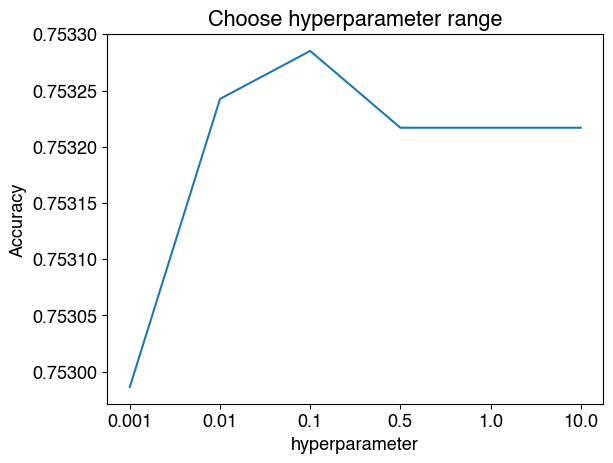

BestHyperparameter: 0.1


In [92]:
plt.plot([str(value) for value in hyperparameter_values], average_accuracies)
plt.xlabel('hyperparameter')
plt.ylabel('Accuracy')
plt.title('Choose hyperparameter range')
plt.savefig('Choose hyperparameter range.pdf', bbox_inches = 'tight')
plt.show()
print("BestHyperparameter:", best_hyperparameter)


For a large range, the best hyperparameter should be in the range(0.01, 0.5). Split the range in smaller slices and try to find a best one.

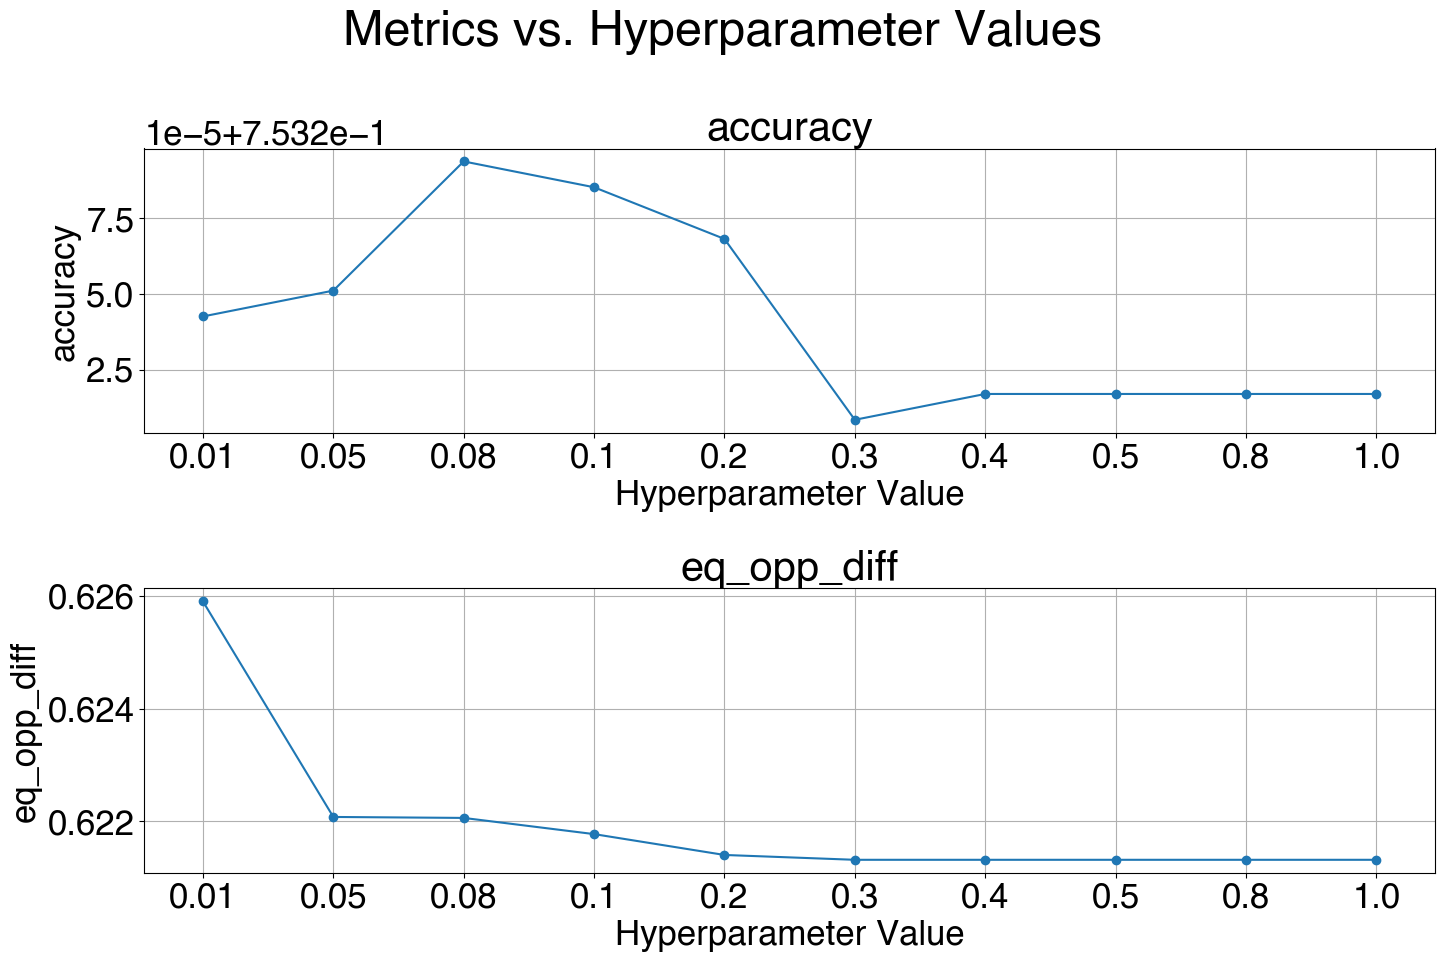

{'accuracy': [0.7532425393843658, 0.7532510780002561, 0.753293771079708, 0.7532852324638176, 0.7532681552320369, 0.7532083849208043, 0.7532169235366948, 0.7532169235366948, 0.7532169235366948, 0.7532169235366948], 'eq_opp_diff': [0.6259004097818233, 0.6220803205291501, 0.622063356607609, 0.6217763731136541, 0.621406840600837, 0.6213210156484184, 0.6213211103541442, 0.6213211103541442, 0.6213211103541442, 0.6213211103541442]}


In [93]:
from aif360.metrics import ClassificationMetric
font = {'family' : 'Helvetica',
        'weight' : 'regular',
        'size'   : 25}
matplotlib.rc('font', **font)

# Define a range for the hyperparameter (e.g., C values for logistic regression)
hyperparameter_values = [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5,0.8, 1.0]
metrics_dict = {
    'accuracy': [],
    'eq_opp_diff': [],
}
for value in hyperparameter_values:
    sum_metrics = {key: 0 for key in metrics_dict}

    for i in range(5):
        
        standard = StandardScaler()
        X_train_train, y_train_train = standard.fit_transform(train_train_splits[i].features), train_train_splits[i].labels.ravel()
        X_train_val, y_train_val = standard.transform(train_val_splits[i].features), train_val_splits[i]

        # Train the model on train-train data with the current hyperparameter value
        model = LogisticRegression(C=value)
        model.fit(X_train_train, y_train_train)
        y_train_val_pred = y_train_val.copy()
        y_train_val_pred.labels = model.predict(X_train_val)
        
        metric = ClassificationMetric(y_train_val, y_train_val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_arrs = {}
        #Statistical Parity Difference measures the difference of the above values instead of ratios, hence we
        #would like it to be close to 0.
        metric_arrs['accuracy']=(metric.accuracy())
        metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
        #Equal opportunity difference measures the ability of the classifier to accurately classify a datapoint as positive
        #regardless of the presence of the unpriviliged feature. We would like it to be close to 0. A negative value signals bias
        #towards priviliged.
        metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
        #Average of difference in FPR and TPR for unprivileged and privileged groups. A value of 0 indicates equality of odds.
        metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
        #We would like Disparate Impact to be close to 1. It measures the ratio between the likelihood of the class being
        #predicted as positive if we have the unpriviliged feature and the the same likelihood with the priviliged feature.
        #Values close to 0 indicate strong bias.
        metric_arrs['disp_imp']=(metric.disparate_impact())
        # Accumulate metrics
        for key in sum_metrics:
            sum_metrics[key] += metric_arrs[key]
    for key in metrics_dict:
        metrics_dict[key].append(sum_metrics[key] / 5)


# Plotting all metrics in one figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
fig.suptitle('Metrics vs. Hyperparameter Values', fontsize=35)
axes = axes.flatten()  # Flatten the axes array for easy indexing

for idx, metric in enumerate(metrics_dict.keys()):
    axes[idx].plot([str(value) for value in hyperparameter_values], metrics_dict[metric], marker='o')
    axes[idx].set_xlabel('Hyperparameter Value')
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(metric)
    axes[idx].grid(True)

# Hide any unused subplots
for i in range(len(metrics_dict), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('task1.pdf', bbox_inches = 'tight')
plt.show()
print(metrics_dict)

Thus, I choose the hyperparameter 0.08 for test.

In [144]:
standard = StandardScaler()
X_train, y_train = standard.fit_transform(dataset_train.features), dataset_train.labels.ravel()
X_test, y_test = standard.transform(dataset_test.features), dataset_test
model = LogisticRegression(C=0.08)
model.fit(X_train, y_train)

y_test_pred = y_test.copy()
y_test_pred.labels = model.predict(X_test)

metric = ClassificationMetric(y_test, y_test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['accuracy']=(metric.accuracy())
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
metric_arrs['disp_imp']=(metric.disparate_impact())
for key, value in metric_arrs.items():
    print(key, ": ", value)

accuracy :  0.7505379343321645
stat_par_diff :  0.5882619580440744
eq_opp_diff :  0.605373070531497
avg_odds_diff :  0.48855339444697665
bal_acc :  0.7482475416673617
disp_imp :  9.353319804225857


## Task 1(c) Model Selection and Performance (Fairness)

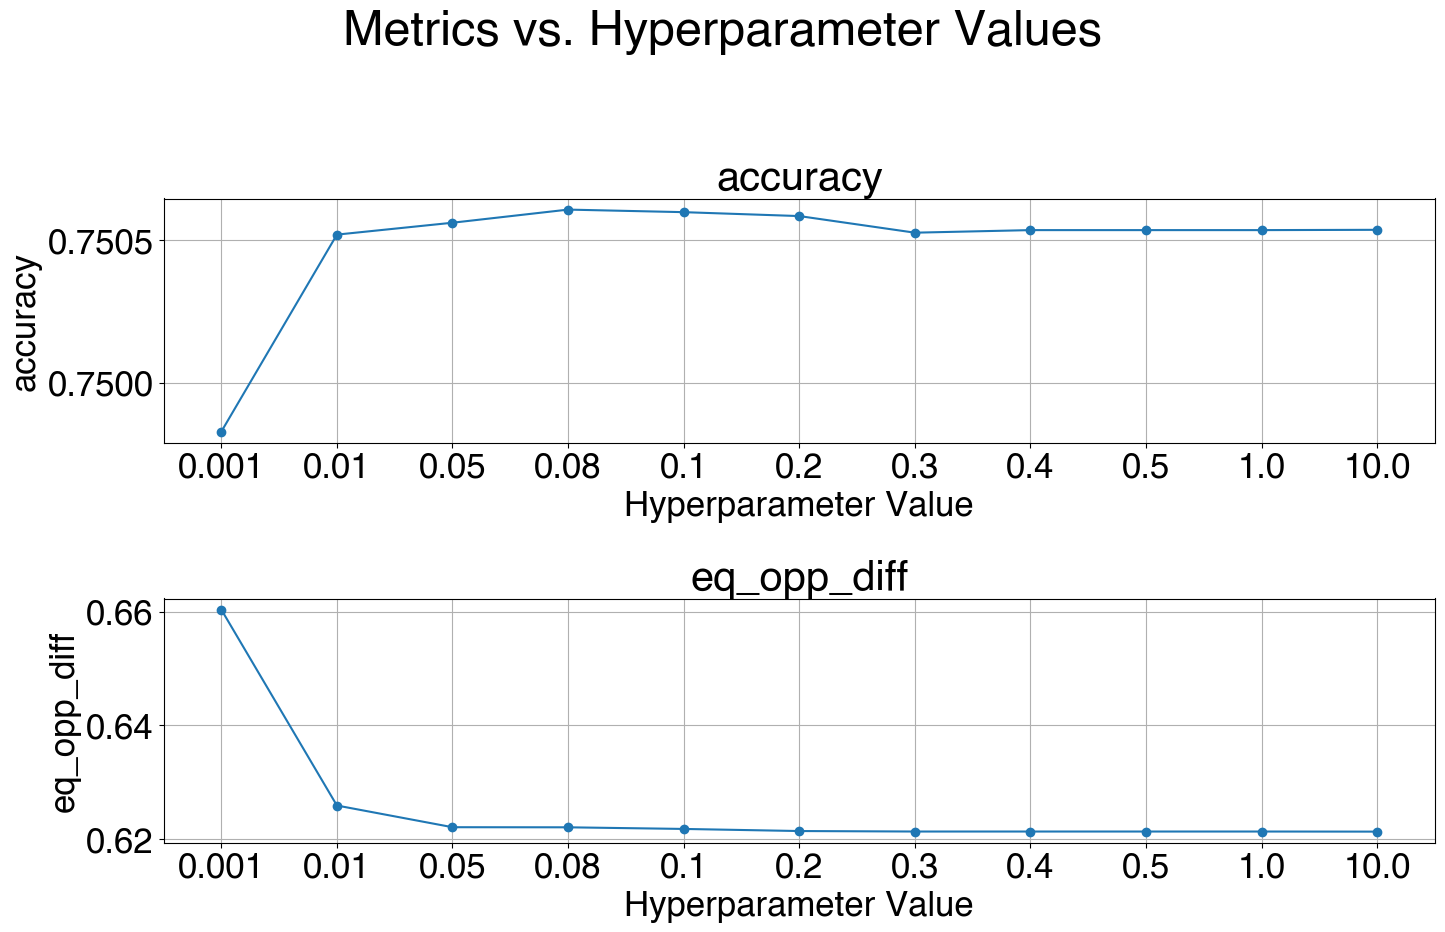

In [136]:
from aif360.metrics import ClassificationMetric
font = {'family' : 'Helvetica',
        'weight' : 'regular',
        'size'   : 25}
matplotlib.rc('font', **font)
# Define a range for the hyperparameter (e.g., C values for logistic regression)
hyperparameter_values = [0.001, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 10.0]
metrics_dict = {
    'accuracy': [],
    'eq_opp_diff': [],
}
models = []
acc = []
eod = []
for value in hyperparameter_values:
    sum_metrics = {key: 0 for key in metrics_dict}

    for i in range(5):
        
        standard = StandardScaler()
        X_train_train, y_train_train = standard.fit_transform(train_train_splits[i].features), train_train_splits[i].labels.ravel()
        X_train_val, y_train_val = standard.transform(train_val_splits[i].features), train_val_splits[i]

        # Train the model on train-train data with the current hyperparameter value
        model = LogisticRegression(C=value)
        model.fit(X_train_train, y_train_train)
        models.append(model)
        y_train_val_pred = y_train_val.copy()
        y_train_val_pred.labels = model.predict(X_train_val)
        
        metric = ClassificationMetric(y_train_val, y_train_val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_arrs = {}
        #Statistical Parity Difference measures the difference of the above values instead of ratios, hence we
        #would like it to be close to 0.
        metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
        #Equal opportunity difference measures the ability of the classifier to accurately classify a datapoint as positive
        #regardless of the presence of the unpriviliged feature. We would like it to be close to 0. A negative value signals bias
        #towards priviliged.
        metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
        eod.append(metric_arrs['eq_opp_diff'])
        #Average of difference in FPR and TPR for unprivileged and privileged groups. A value of 0 indicates equality of odds.
        metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
        #Balanced accuracy is a general metric, not dependent on bias. We would like to have it close to 1, meaning
        #that the classifier can equally detect positive and negative classes.
        metric_arrs['accuracy']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
        #We would like Disparate Impact to be close to 1. It measures the ratio between the likelihood of the class being
        #predicted as positive if we have the unpriviliged feature and the the same likelihood with the priviliged feature.
        #Values close to 0 indicate strong bias.
        metric_arrs['disp_imp']=(metric.disparate_impact())
        # Accumulate metrics
        for key in sum_metrics:
            sum_metrics[key] += metric_arrs[key]
    for key in metrics_dict:
        metrics_dict[key].append(sum_metrics[key] / 5)


# Plotting all metrics in one figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
fig.suptitle('Metrics vs. Hyperparameter Values', fontsize=35)
axes = axes.flatten()  # Flatten the axes array for easy indexing

for idx, metric in enumerate(metrics_dict.keys()):
    axes[idx].plot([str(value) for value in hyperparameter_values], metrics_dict[metric], marker='o')
    axes[idx].set_xlabel('Hyperparameter Value')
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(metric)
    axes[idx].grid(True)

# Hide any unused subplots
for i in range(len(metrics_dict), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('task1.pdf', bbox_inches = 'tight')
plt.show()

In [96]:
max_accuracy_index = np.argmax(acc)
min_eod_index = np.argmin(eod)

best_model_accuracy = models[max_accuracy_index]
best_model_eod = models[min_eod_index]

y_test_pred = y_test.copy()
y_test_pred.labels = best_model_eod.predict(X_test)

metric = ClassificationMetric(y_test, y_test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['accuracy']=(metric.accuracy())
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
metric_arrs['disp_imp']=(metric.disparate_impact())
for key, value in metric_arrs.items():
    print(key, ": ", value)

accuracy :  0.7508965572202742
stat_par_diff :  0.5858960642477549
eq_opp_diff :  0.598482409719838
avg_odds_diff :  0.4842529836978307
bal_acc :  0.7485538102006873
disp_imp :  8.965693299027986


As the hyperparameter value increases, fairness metrics tend to improve, but the balanced accuracy slightly decreases. The key is to find an optimal hyperparameter value that maximizes both fairness and accuracy. This value seems to be in the middle range of the hyperparameter values you've tested, where fairness metrics are improved without a significant loss in balanced accuracy. However, one must also consider the actual numerical values of these metrics in the context of the problem to make a definitive conclusion. Finally, I choose C=0.02 as the best trade-off of fairness and accuracy.

## Task 2(a) Using RW

In [97]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)


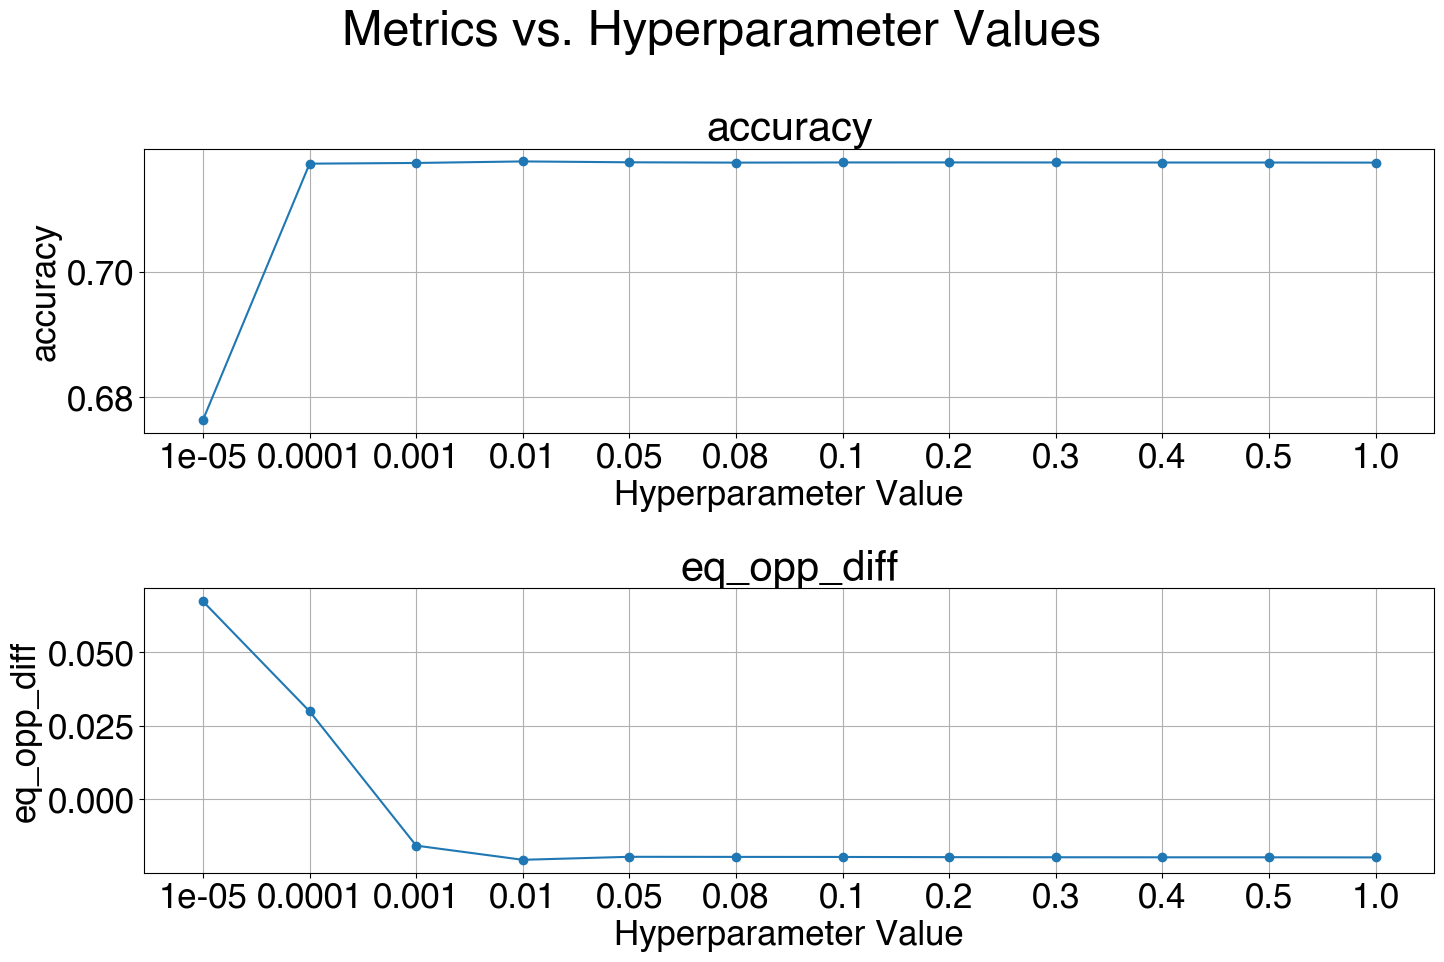

In [133]:
# Define a range for the hyperparameter (e.g., C values for logistic regression)
font = {'family' : 'Helvetica',
        'weight' : 'regular',
        'size'   : 25}
matplotlib.rc('font', **font)
hyperparameter_values = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
metrics_dict = {
    'accuracy': [],

    'eq_opp_diff': [],
}
for value in hyperparameter_values:
    sum_metrics = {key: 0 for key in metrics_dict}

    for i in range(5):
        
        standard = StandardScaler()
        train = RW.fit_transform(train_train_splits[i])
        
        X_train_train, y_train_train = standard.fit_transform(train_train_splits[i].features), train_train_splits[i].labels.ravel()
        X_train_val, y_train_val = standard.transform(train_val_splits[i].features), train_val_splits[i]

        # Train the model on train-train data with the current hyperparameter value
        model = LogisticRegression(C=value)
        model.fit(X_train_train, y_train_train, sample_weight=train.instance_weights)
        y_train_val_pred = y_train_val.copy()
        y_train_val_pred.labels = model.predict(X_train_val)
        metric = ClassificationMetric(y_train_val, y_train_val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_arrs = {}
        #Statistical Parity Difference measures the difference of the above values instead of ratios, hence we would like it to be close to 0.
        metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
        #Equal opportunity difference measures the ability of the classifier to accurately classify a datapoint as positive
        #regardless of the presence of the unpriviliged feature. We would like it to be close to 0. A negative value signals bias
        #towards priviliged.
        metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
        #Average of difference in FPR and TPR for unprivileged and privileged groups. A value of 0 indicates equality of odds.
        metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
        #Balanced accuracy is a general metric, not dependent on bias. We would like to have it close to 1, meaning
        #that the classifier can equally detect positive and negative classes.
        metric_arrs['accuracy']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
        #We would like Disparate Impact to be close to 1. It measures the ratio between the likelihood of the class being
        #predicted as positive if we have the unpriviliged feature and the the same likelihood with the priviliged feature.
        #Values close to 0 indicate strong bias.
        metric_arrs['disp_imp']=(metric.disparate_impact())
        # Accumulate metrics
        for key in sum_metrics:
            sum_metrics[key] += metric_arrs[key]
    for key in metrics_dict:
        metrics_dict[key].append(sum_metrics[key] / 5)


# Plotting all metrics in one figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
fig.suptitle('Metrics vs. Hyperparameter Values', fontsize=35)
axes = axes.flatten()  # Flatten the axes array for easy indexing

for idx, metric in enumerate(metrics_dict.keys()):
    axes[idx].plot([str(value) for value in hyperparameter_values], metrics_dict[metric], marker='o')
    axes[idx].set_xlabel('Hyperparameter Value')
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(metric)
    axes[idx].grid(True)

# Hide any unused subplots
for i in range(len(metrics_dict), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('task2.pdf', bbox_inches = 'tight')

In [ ]:
standard = StandardScaler()
train = RW.fit_transform(dataset_train)
X_train, y_train = standard.fit_transform(dataset_train.features), dataset_train.labels.ravel()
X_test, y_test = standard.transform(dataset_test.features), dataset_test
model = LogisticRegression(C=0.001)
model.fit(X_train, y_train, sample_weight=train.instance_weights)

y_test_pred = y_test.copy()
y_test_pred.labels = model.predict(X_test)
metric = ClassificationMetric(y_test, y_test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['accuracy']=(metric.accuracy())
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
metric_arrs['disp_imp']=(metric.disparate_impact())
for key, value in metric_arrs.items():
    print(key, ": ", value)

accuracy :  0.7194772075231113
stat_par_diff :  0.1772175842643774
eq_opp_diff :  -0.028072568092718964
avg_odds_diff :  -0.010293223578283245
bal_acc :  0.7174445813425621
disp_imp :  1.4360623437453148


## Task 3

In [114]:
confidence_thresholds = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]

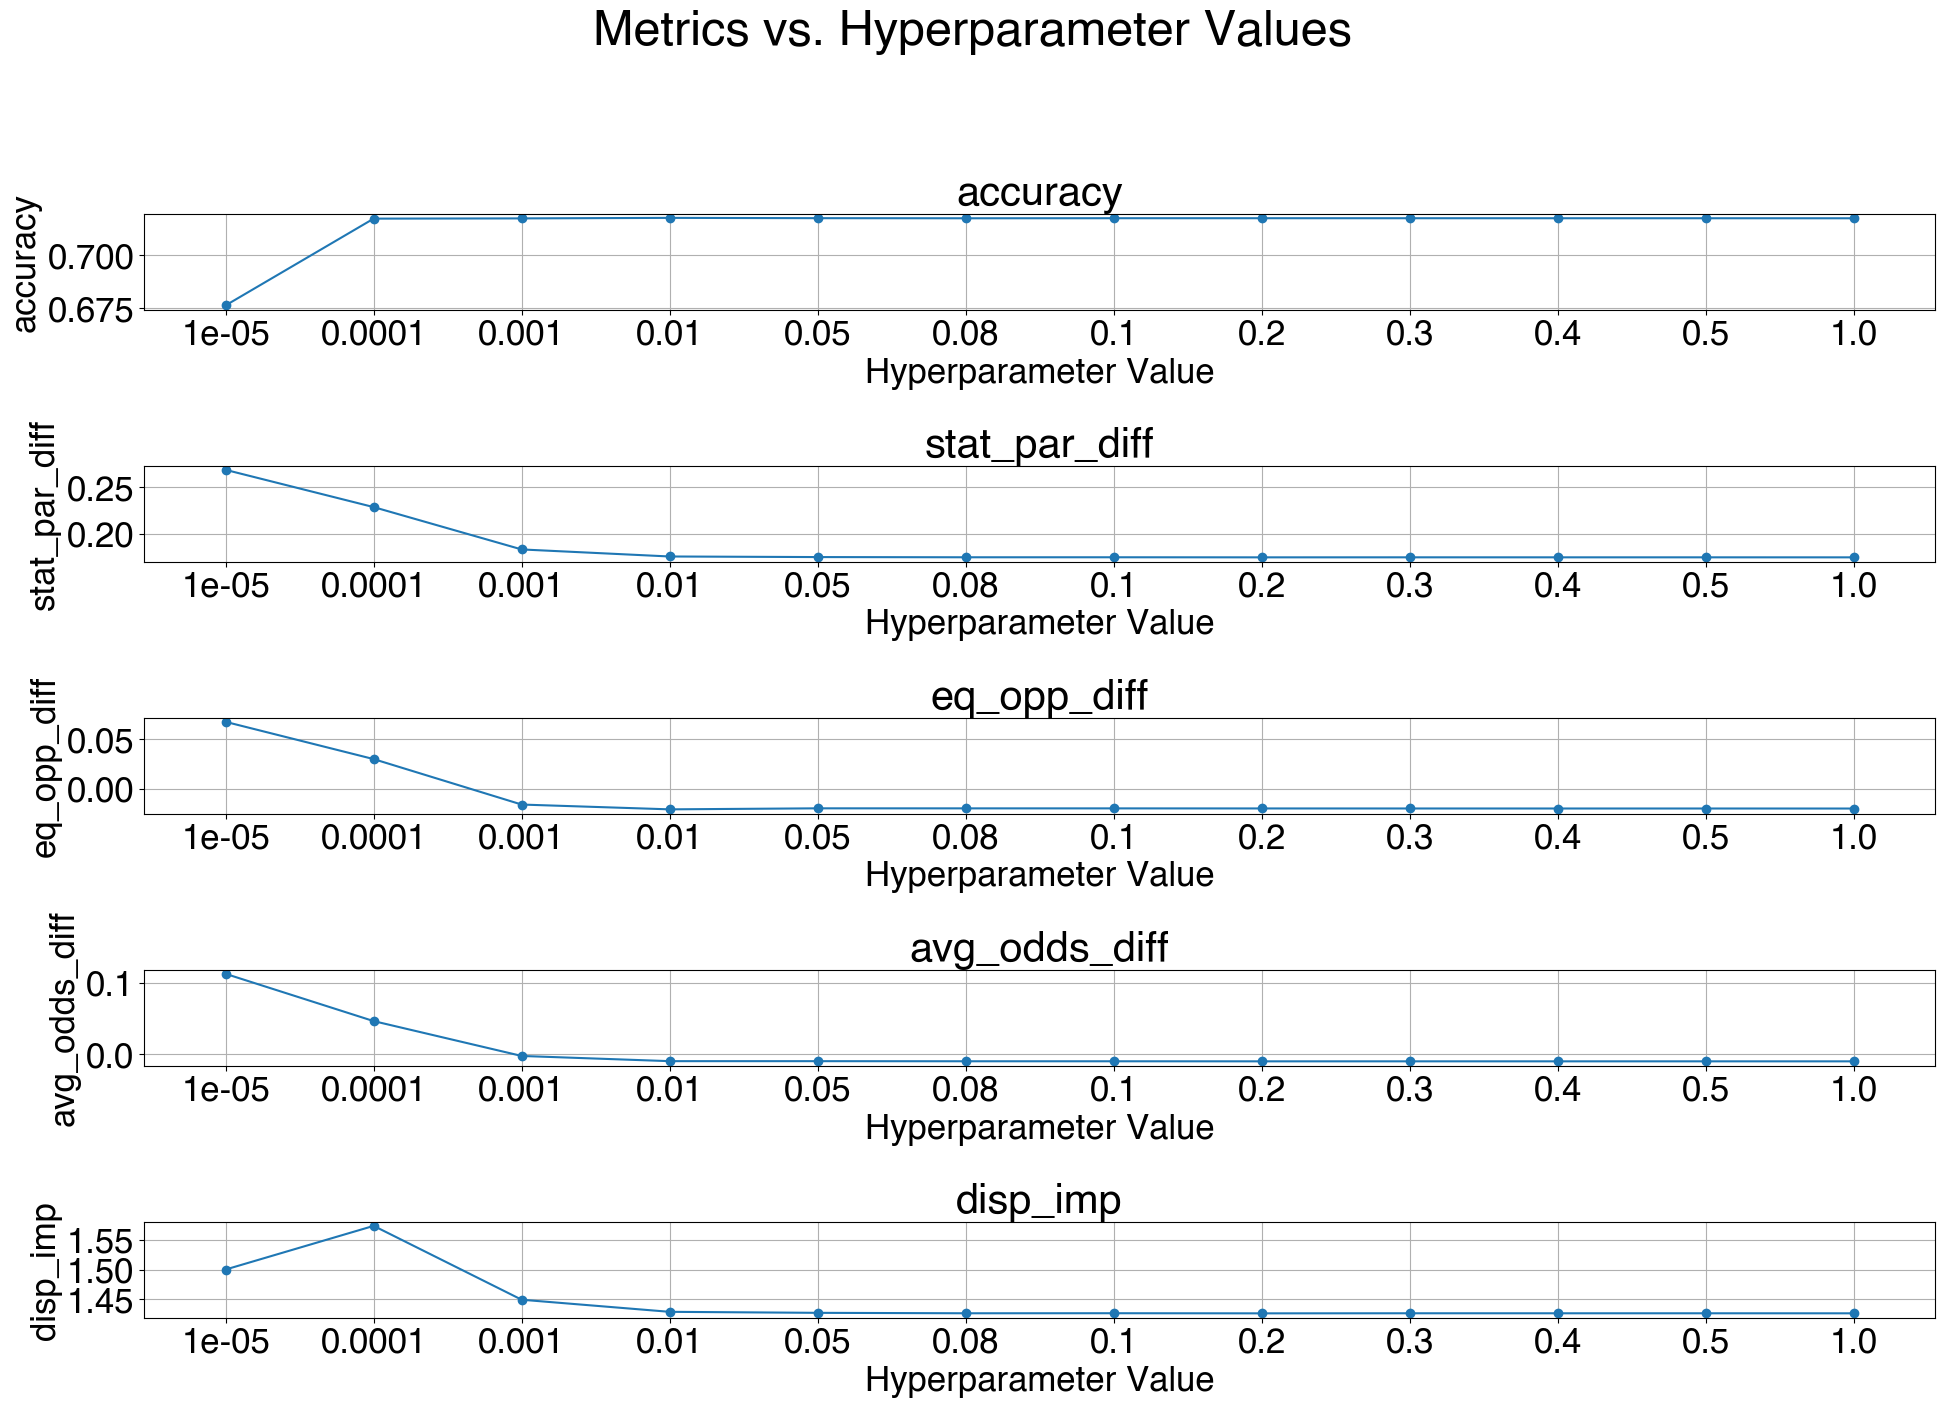

In [124]:
metrics_dict = {
    'accuracy': [],
    'stat_par_diff': [],
    'eq_opp_diff': [],
    'avg_odds_diff': [],
    'disp_imp': []
}
font = {'family' : 'Helvetica',
        'weight' : 'regular',
        'size'   : 25}
matplotlib.rc('font', **font)
    
for value in confidence_thresholds:
    sum_metrics = {key: 0 for key in metrics_dict}

    for i in range(5):
        standard = StandardScaler()
        train = RW.fit_transform(train_train_splits[i])
        
        X_train_train, y_train_train = standard.fit_transform(train_train_splits[i].features), train_train_splits[i].labels.ravel()
        X_train_val, y_train_val = standard.transform(train_val_splits[i].features), train_val_splits[i]
        # Train the model on train-train data with the current hyperparameter value
        model = LogisticRegression(C=value)
        
        model.fit(X_train_train, y_train_train, sample_weight=train.instance_weights)

        y_train_val_pred = y_train_val.copy()
        # y_train_val_pred_prob = model.predict_proba(X_train_val)[:,1]
        y_train_val_pred.labels = model.predict(X_train_val)
 
        
        metric = ClassificationMetric(y_train_val, y_train_val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        metric_arrs = {}
        metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
        metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
        metric_arrs['accuracy']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
        metric_arrs['disp_imp']=(metric.disparate_impact())
        # Accumulate metrics
        for key in sum_metrics:
            sum_metrics[key] += metric_arrs[key]
        
    for key in metrics_dict:
        metrics_dict[key].append(sum_metrics[key] / 5)
        


# Plotting all metrics in one figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 15))
fig.suptitle('Metrics vs. Hyperparameter Values', fontsize=35)
axes = axes.flatten()  # Flatten the axes array for easy indexing

for idx, metric in enumerate(metrics_dict.keys()):
    axes[idx].plot([str(value) for value in confidence_thresholds], metrics_dict[metric], marker='o')
    axes[idx].set_xlabel('Hyperparameter Value')
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(metric)
    axes[idx].grid(True)

# Hide any unused subplots
for i in range(len(metrics_dict), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('task3.pdf', bbox_inches = 'tight')
plt.show()

In [134]:
standard = StandardScaler()
train = RW.fit_transform(dataset_train)
X_train, y_train = standard.fit_transform(dataset_train.features), dataset_train.labels.ravel()
X_test, y_test = standard.transform(dataset_test.features), dataset_test
model = LogisticRegression(C=0.1)
model.fit(X_train, y_train, sample_weight=train.instance_weights)

y_test_pred = y_test.copy()
y_test_pred.labels = model.predict(X_test)
metric = ClassificationMetric(y_test, y_test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['accuracy']=(metric.accuracy())
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
metric_arrs['disp_imp']=(metric.disparate_impact())
for key, value in metric_arrs.items():
    print(key, ": ", value)

accuracy :  0.7200350653490596
stat_par_diff :  0.17143281807158584
eq_opp_diff :  -0.03646496413108524
avg_odds_diff :  -0.017813230565919352
bal_acc :  0.7181867540820404
disp_imp :  1.420955489128189


## Additional Research

In [145]:
import folktables
from folktables import ACSDataSource
import numpy as np
#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):

#Filters for the employment prediction task

    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df

ACSEmployment = folktables.BasicProblem(
    features=[
    'AGEP', #age; for range of values of features please check Appendix B.4 of Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
    'SCHL', #educational attainment
    'MAR', #marital status
    'RELP', #relationship
    'DIS', #disability recode
    'ESP', #employment status of parents
    'CIT', #citizenship status
    'MIG', #mobility status (lived here 1 year ago)
    'MIL', #military service
    'ANC', #ancestry recode
    'NATIVITY', #nativity
    'DEAR', #hearing difficulty
    'DEYE', #vision difficulty
    'DREM', #cognitive difficulty
    'SEX', #sex
    'RAC1P', #recoded detailed race code
    'GCL', #grandparents living with grandchildren
    ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group='DIS',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["TX"], download=True) #data for Florida state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

from aif360.datasets import StandardDataset
import pandas as pd
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes, protected_attribute_names = protected_attribute_names, privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]

dataset_test = data_for_aif

/opt/anaconda3/envs/AIETHic/lib/python3.10/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


In [149]:
standard = StandardScaler()
train = RW.fit_transform(data_for_aif)
X_train, y_train = standard.fit_transform(data_for_aif.features), data_for_aif.labels.ravel()
X_test, y_test = standard.transform(dataset_test.features), dataset_test
model = LogisticRegression(C=0.1)
model.fit(X_train, y_train, sample_weight=train.instance_weights)

y_test_pred = y_test.copy()
y_test_pred.labels = model.predict(X_test)
metric = ClassificationMetric(y_test, y_test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['accuracy']=(metric.accuracy())
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
metric_arrs['disp_imp']=(metric.disparate_impact())
for key, value in metric_arrs.items():
    print(key, ": ", value)

accuracy :  0.7010913907793317
stat_par_diff :  0.16357471644243382
eq_opp_diff :  -0.00764027839328274
avg_odds_diff :  0.009958024553804262
bal_acc :  0.6805359644488823
disp_imp :  1.3141516278143954


In [181]:
# Initial train-test split (0.7/0.3)
dataset_train, dataset_test = data_for_aif.split([0.7], shuffle=True, seed=777)
dataset_test = StandardDataset(data, 'label', favorable_classes = favorable_classes,protected_attribute_names=[],features_to_drop = 'DIS' , privileged_classes = privileged_classes) 

/opt/anaconda3/envs/AIETHic/lib/python3.10/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


In [180]:
standard = StandardScaler()
# train = RW.fit_transform(data_for_aif)
X_train, y_train = standard.fit_transform(dataset_train.features), dataset_train.labels.ravel()
X_test, y_test = standard.transform(dataset_test.features), dataset_test
model = LogisticRegression(C=0.08)
model.fit(X_train, y_train)

y_test_pred = y_test.copy()
y_test_pred.labels = model.predict(X_test)
# metric = ClassificationMetric(y_test, y_test_pred, unprivileged_groups=None, privileged_groups=None)
metric_arrs = {}
metric_arrs['accuracy']=(accuracy_score(y_test.labels.ravel(), y_test_pred.labels.ravel()))
for key, value in metric_arrs.items():
    print(key, ": ", value)

accuracy :  0.7329116232638055
